# Exploring Asymmetries in Gendered Categories

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import latextable as lt
import texttable as tt
from Code import helper_functions as helper
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import kruskal

import warnings
warnings.filterwarnings('ignore')

Asymmetry is calculates as 
- A negative asymmetry shows a system has more categories 
- A positive asymmetry shows 
- An asymmetry near zero suggests a system is gender balanced 

In [2]:
def asymmetry(w, m):
    return (len(w) / (len(w) + len(m))) - 0.5

## Load Datasets

Right now for language i'm just using the bigrams from google ngram 2020

In [3]:
lcsh_gendered = pd.read_csv('Data/LCSH/lcsh-gendered.csv')
print(lcsh_gendered.head())
print('')

wikipedia_gendered = pd.read_csv('Data/Wikipedia/wikipedia-gendered.csv')
print(wikipedia_gendered.head())
print('')

ngrams_gendered_curr = pd.read_csv('Data/Google Ngram/ngrams_2010-2019.csv')
print(ngrams_gendered_curr.head())
print('')

ngrams_gendered_20th = pd.read_csv('Data/Google Ngram/ngrams_20th_century.csv')
print(ngrams_gendered_20th.tail())
print('')

                      CATEGORY                      CLEANED  YEAR_ADDED GENDER
0    Women marine mammalogists    women marine mammalogists        2000      W
1      Overweight women in art      overweight women in art        2000      W
2         Women dermatologists         women dermatologists        2000      W
3            Women librettists            women librettists        2000      W
4  Motion pictures and gay men  motion pictures and gay men        2000      M

                     CATEGORY                     CLEANED GENDER
0            Middle-earth_Men            middle earth men      M
1       American_male_writers       american male writers      M
2                Men's_health               men 's health      M
3  Female_legendary_creatures  female legendary creatures      W
4    Women_in_Greek_mythology    women in greek mythology      W

          GRAM  FREQ GENDER
0      <M> aaf    12      M
1    <M> aaron   149      M
2   <M> abakua     4      M
3  <M> abalone     9  

## Overall

### The LCSH

In [4]:
w_lcsh, m_lcsh, wm_lcsh = helper.get_concepts(lcsh_gendered, ['men', 'male', 'women', 'female'])
total_gendered_lcsh = len(m_lcsh) + len(w_lcsh) + (len(wm_lcsh)*2)
total_concepts_lcsh = len(m_lcsh) + len(w_lcsh) + len(wm_lcsh)
asymmetry_lcsh = asymmetry(w_lcsh, m_lcsh)
print(f'There are {total_gendered_lcsh:,} gendered categories in the LCSH that cover {total_concepts_lcsh:,} concepts.')
print(f'\t-{len(m_lcsh):,} concepts just  have categories for men')
print(f'\t-{len(w_lcsh):,} concepts just have categories for women')
print(f'\t-{len(wm_lcsh):,} concepts are gender balanced')

print(f'\nThe gender asymmetry of unbalanced concepts is: {asymmetry_lcsh:.3f}.')

There are 2,864 gendered categories in the LCSH that cover 2,668 concepts.
	-182 concepts just  have categories for men
	-2,290 concepts just have categories for women
	-196 concepts are gender balanced

The gender asymmetry of unbalanced concepts is: 0.426.


In [5]:
with open('Outputs/Category Lists/Overall/w-lcsh.txt', 'w') as f:
    for item in w_lcsh:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Overall/m-lcsh.txt', 'w') as f:
    for item in m_lcsh:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Overall/wm-lcsh.txt', 'w') as f:
    for item in wm_lcsh:
        f.write(f"{item}\n")

### Wikipedia 

In [6]:
w_wiki, m_wiki, wm_wiki = helper.get_concepts(wikipedia_gendered, ['men', 'male', 'women', 'female'])
total_gendered_wiki = len(m_wiki) + len(w_wiki) + (len(wm_wiki)*2)
total_concepts_wiki = len(m_wiki) + len(w_wiki) + len(wm_wiki)
asymmetry_wiki = asymmetry(w_wiki, m_wiki)
print(f'There are {total_gendered_wiki:,} gendered categories in the Wikipedia that cover {total_concepts_wiki:,} concepts.')
print(f'\t-{len(m_wiki):,} concepts just  have categories for men')
print(f'\t-{len(w_wiki):,} concepts just have categories for women')
print(f'\t-{len(wm_wiki):,} concepts are gender balanced')

print(f'\nThe gender asymmetry of unbalanced concepts is: {asymmetry_wiki:.3f}.')


There are 19,672 gendered categories in the Wikipedia that cover 15,955 concepts.
	-2,759 concepts just  have categories for men
	-9,479 concepts just have categories for women
	-3,717 concepts are gender balanced

The gender asymmetry of unbalanced concepts is: 0.275.


In [7]:
with open('Outputs/Category Lists/Overall/w-wiki.txt', 'w') as f:
    for item in w_wiki:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Overall/m-wiki.txt', 'w') as f:
    for item in m_wiki:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Overall/wm-wiki.txt', 'w') as f:
    for item in wm_wiki:
        f.write(f"{item}\n")

### Language (2010-2019)
Specifically language used in texts from Google Books

In [8]:
MIN_FREQ = 40
paired_curr = helper.group_ngrams(ngrams_gendered_curr, MIN_FREQ)
w_lang_curr, wm_lang_curr, m_lang_curr = helper.get_case_counts(paired_curr)
total_concepts_lang = w_lang_curr + wm_lang_curr + m_lang_curr 
asymmetry_lang = (w_lang_curr / (w_lang_curr + m_lang_curr)) - 0.5
print(f'There are {total_concepts_lang:,} concepts where both gendered subcategories occur more than {MIN_FREQ} times')
print(f'\t-The are {w_lang_curr:,} where the term for women is much more frequent')
print(f'\t-The are {m_lang_curr:,} where the term for men is much more frequent')
print(f'\t-The are {m_lang_curr:,} where they occur at roughly equal rates')

print(f'\nThe asymmetry of unbalanced concepts is {asymmetry_lang:.3f}')

There are 31,586 concepts where both gendered subcategories occur more than 40 times
	-The are 13,198 where the term for women is much more frequent
	-The are 8,222 where the term for men is much more frequent
	-The are 8,222 where they occur at roughly equal rates

The asymmetry of unbalanced concepts is 0.116


In [ ]:
with open('Outputs/Category Lists/Overall/w-ngram.txt', 'w') as f:
    w = paired_curr[paired_curr['CASE'] == 'W']
    for _, row in w.iterrows():
        f.write(f"{row['CATEGORY'].replace('<P>', '[men/male/women/female]')}\n")

(13198, 4)
            CATEGORY    PROP_W  TOTAL_GEN_FREQ CASE
5      <P> abductees  0.818627             408    W
7        <P> ability  0.632796            2421    W
8      <P> abjection  0.776119             402    W
10  <P> abolitionist  0.797664            5308    W
11    <P> aboriginal  0.608173             416    W


### Language (20th Century)

In [10]:
paired_20th = helper.group_ngrams(ngrams_gendered_20th, MIN_FREQ)
w_lang_20th, wm_lang_20th, m_lang_20th = helper.get_case_counts(paired_20th)
total_concepts_lang_20th = w_lang_20th + wm_lang_20th + m_lang_20th
asymmetry_lang_20th = (w_lang_20th / (w_lang_20th + m_lang_20th)) - 0.5
print(f'There are {total_concepts_lang_20th:,} concepts where both gendered subcategories occur more than {MIN_FREQ} times')
print(f'\t-The are {w_lang_20th:,} where the term for women is much more frequent')
print(f'\t-The are {m_lang_20th:,} where the term for men is much more frequent')
print(f'\t-The are {wm_lang_20th:,} where they occur at roughly equal rates')

print(f'\nThe asymmetry of unbalanced concepts is {asymmetry_lang_20th:.3f}')

There are 60,427 concepts where both gendered subcategories occur more than 40 times
	-The are 19,926 where the term for women is much more frequent
	-The are 22,294 where the term for men is much more frequent
	-The are 18,207 where they occur at roughly equal rates

The asymmetry of unbalanced concepts is -0.028


## Jobs
To get a list of job titles I process job_titles_dictionary.txt from [this GitHub repository](https://github.com/johnpcarty/Thesaurus-of-Job-Titles) by John Carty.

In [11]:
job_df = pd.read_csv('Data/Jobs/jobs_with_synonyms.csv')

### The LCSH

In [12]:
lcsh_jobs = helper.get_gendered_jobs(job_df, lcsh_gendered, ['men', 'male', 'women', 'female'])
w_lcsh_jobs, m_lcsh_jobs, wm_lcsh_jobs = helper.get_concepts(lcsh_jobs, ['men', 'male', 'women', 'female'])
total_gendered_lcsh_jobs = len(m_lcsh_jobs) + len(w_lcsh_jobs) + (len(wm_lcsh_jobs)*2)
total_jobs_lcsh = len(m_lcsh_jobs) + len(w_lcsh_jobs) + len(wm_lcsh_jobs)
asymmetry_lcsh_jobs = asymmetry(w_lcsh_jobs, m_lcsh_jobs)
print(f'There are {total_gendered_lcsh_jobs:,} gendered job categories in the LCSH that cover {total_jobs_lcsh:,} unique jobs.')
print(f'\t-{len(m_lcsh_jobs):,} jobs just have categories for men')
print(f'\t-{len(w_lcsh_jobs):,} jobs just have categories for women')
print(f'\t-{len(wm_lcsh_jobs):,} jobs are gender balanced')

print(f'\nThe gender asymmetry of unbalanced jobs is: {asymmetry_lcsh_jobs:.3f}.')


There are 285 gendered job categories in the LCSH that cover 267 unique jobs.
	-9 jobs just have categories for men
	-240 jobs just have categories for women
	-18 jobs are gender balanced

The gender asymmetry of unbalanced jobs is: 0.464.


In [13]:
with open('Outputs/Category Lists/Jobs/w-lcsh-jobs.txt', 'w') as f:
    for item in w_lcsh_jobs:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Jobs/m-lcsh-jobs.txt', 'w') as f:
    for item in m_lcsh_jobs:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Jobs/wm-lcsh-jobs.txt', 'w') as f:
    for item in wm_lcsh_jobs:
        f.write(f"{item}\n")

### Wikipedia

In [14]:
wiki_jobs = helper.get_gendered_jobs(job_df, wikipedia_gendered, ['men', 'male', 'women', 'female'])
w_wiki_jobs, m_wiki_jobs, wm_wiki_jobs = helper.get_concepts(wiki_jobs, ['men', 'male', 'women', 'female'])
total_gendered_wiki_jobs = len(m_wiki_jobs) + len(w_wiki_jobs) + (len(wm_wiki_jobs)*2)
total_jobs_wiki = len(m_wiki_jobs) + len(w_wiki_jobs) + len(wm_wiki_jobs)
asymmetry_wiki_jobs = asymmetry(w_wiki_jobs, m_wiki_jobs)
print(f'There are {total_gendered_wiki_jobs:,} gendered categories for jobs in the Wikipedia that cover {total_jobs_wiki:,} jobs.')
print(f'\t-{len(m_wiki_jobs):,} jobs just  have categories for men')
print(f'\t-{len(w_wiki_jobs):,} jobs just have categories for women')
print(f'\t-{len(wm_wiki_jobs):,} jobs are gender balanced')

print(f'\nThe gender asymmetry of unbalanced jobs is: {asymmetry_wiki_jobs:.3f}.')

There are 187 gendered categories for jobs in the Wikipedia that cover 143 jobs.
	-2 jobs just  have categories for men
	-97 jobs just have categories for women
	-44 jobs are gender balanced

The gender asymmetry of unbalanced jobs is: 0.480.


In [15]:
with open('Outputs/Category Lists/Jobs/w-wiki-jobs.txt', 'w') as f:
    for item in w_wiki_jobs:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Jobs/m-wiki-jobs.txt', 'w') as f:
    for item in m_wiki_jobs:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Jobs/wm-wiki-jobs.txt', 'w') as f:
    for item in wm_wiki_jobs:
        f.write(f"{item}\n")

### Language (2010-2019)


In [16]:
jobs_lang = helper.get_gendered_jobs_lang(job_df, paired_curr)
w_lang_jobs, wm_lang_jobs, m_lang_jobs = helper.get_case_counts(jobs_lang)
total_concepts_lang_jobs = w_lang_jobs + wm_lang_jobs + m_lang_jobs
asymmetry_lang_jobs = (w_lang_jobs / (w_lang_jobs + m_lang_jobs)) - 0.5

print(f'There are {total_concepts_lang_jobs:,} jobs where both gendered subcategories occur more than {MIN_FREQ} times')
print(f'\t-The are {w_lang_jobs:,} where the term for women is much more frequent')
print(f'\t-The are {m_lang_jobs:,} where the term for men is much more frequent')
print(f'\t-The are {wm_lang_jobs:,} where they occur at roughly equal rates')

print(f'\nThe asymmetry of unbalanced concepts is {asymmetry_lang_jobs:.3f}')

There are 596 jobs where both gendered subcategories occur more than 40 times
	-The are 424 where the term for women is much more frequent
	-The are 34 where the term for men is much more frequent
	-The are 138 where they occur at roughly equal rates

The asymmetry of unbalanced concepts is 0.426


### Language (20th Century)

In [17]:
jobs_lang_20th = helper.get_gendered_jobs_lang(job_df, paired_20th)
w_lang_jobs_20th, wm_lang_jobs_20th, m_lang_jobs_20th = helper.get_case_counts(jobs_lang_20th)
total_concepts_lang_jobs_20th = w_lang_jobs_20th + wm_lang_jobs_20th + m_lang_jobs_20th
asymmetry_lang_jobs_20th = (w_lang_jobs_20th / (w_lang_jobs_20th + m_lang_jobs_20th)) - 0.5

print(f'There are {total_concepts_lang_jobs_20th:,} jobs where both gendered subcategories occur more than {MIN_FREQ} times')
print(f'\t-The are {w_lang_jobs_20th:,} where the term for women is much more frequent')
print(f'\t-The are {m_lang_jobs_20th:,} where the term for men is much more frequent')
print(f'\t-The are {wm_lang_jobs_20th:,} where they occur at roughly equal rates')

print(f'\nThe asymmetry of unbalanced concepts is {asymmetry_lang_jobs_20th:.3f}')

There are 748 jobs where both gendered subcategories occur more than 40 times
	-The are 514 where the term for women is much more frequent
	-The are 59 where the term for men is much more frequent
	-The are 175 where they occur at roughly equal rates

The asymmetry of unbalanced concepts is 0.397


### Can frequency or perceived frequency explain the asymmetry?

In [18]:
job_gender_stats = pd.read_csv('Data/Jobs/occupation_percentages_gender_occ1950.csv')
jobs_perceived_gender_stats = pd.read_csv('Data/Jobs/role nouns.txt', sep=',')
jobs_perceived_gender_stats['ROLE_NOUN'] = jobs_perceived_gender_stats['ROLE_NOUN'].str.lower()

jobs_2015 = job_gender_stats[job_gender_stats['Census year'] == 2015][['Occupation', 'Female', 'Male']]
jobs_2015.rename(columns={'Female': 'PROP_W', 'Male': 'PROP_M', 'Occupation': 'JOB'}, inplace=True)
jobs_2015.to_csv('Outputs/jobs-2015.csv')

jobs_2019 = pd.read_csv('Data/Jobs/us_job_stats_2019.csv')

combined_jobs = helper.combine_job_datasets(jobs_2015, jobs_2019)


In [19]:
jobs_with_prop_lcsh = helper.get_job_stats(lcsh_jobs, combined_jobs, ['men', 'male', 'women', 'female'])
jobs_with_prop_lcsh = jobs_with_prop_lcsh.groupby(['JOB', 'PROP_W']).sum().reset_index()
jobs_with_prop_lcsh['GENDER'] = jobs_with_prop_lcsh['GENDER'].apply(helper.get_label)

jobs_with_prop_wiki = helper.get_job_stats(wiki_jobs, combined_jobs, ['men', 'male', 'women', 'female'])
jobs_with_prop_wiki = jobs_with_prop_wiki.groupby(['JOB', 'PROP_W'], ).sum().reset_index()
jobs_with_prop_wiki['GENDER'] = jobs_with_prop_wiki['GENDER'].apply(helper.get_label)

jobs_with_prop_lang = helper.get_job_stats_ngram(jobs_lang, combined_jobs).reset_index(drop=True)
jobs_with_prop_lang['JOB'] = jobs_with_prop_lang['JOB'].str.replace('<P>', '').str.strip()
jobs_with_prop_lang.rename(columns={'CASE': 'GENDER'}, inplace=True)

jobs_with_prop_lang_20th = helper.get_job_stats_ngram(jobs_lang_20th, combined_jobs).reset_index(drop=True)
jobs_with_prop_lang_20th['JOB'] = jobs_with_prop_lang_20th['JOB'].str.replace('<P>', '').str.strip()
jobs_with_prop_lang_20th.rename(columns={'CASE': 'GENDER'}, inplace=True)

In [20]:
jobs_perceived_gender_stats = jobs_perceived_gender_stats.rename(columns={'ROLE_NOUN':'JOB'})

jobs_with_perc_prop_lang = helper.get_job_stats_ngram(jobs_lang, jobs_perceived_gender_stats).reset_index(drop=True)
jobs_with_perc_prop_lang['JOB'] = jobs_with_perc_prop_lang['JOB'].str.replace('<P>', '').str.strip()
jobs_with_perc_prop_lang.rename(columns=({'CASE': 'GENDER'}), inplace=True)

jobs_with_perc_prop_lang_20th = helper.get_job_stats_ngram(jobs_lang_20th, jobs_perceived_gender_stats).reset_index(drop=True)
jobs_with_perc_prop_lang_20th['JOB'] = jobs_with_perc_prop_lang_20th['JOB'].str.replace('<P>', '').str.strip()
jobs_with_perc_prop_lang_20th.rename(columns=({'CASE': 'GENDER'}), inplace=True)


jobs_with_perc_prop_lcsh = helper.get_job_stats(lcsh_jobs, jobs_perceived_gender_stats, ['men', 'male', 'women', 'female'])
jobs_with_perc_prop_lcsh = jobs_with_perc_prop_lcsh.groupby(['JOB', 'PROP_W']).sum().reset_index()
jobs_with_perc_prop_lcsh['GENDER'] = jobs_with_perc_prop_lcsh['GENDER'].apply(helper.get_label)

jobs_with_perc_prop_wiki = helper.get_job_stats(wiki_jobs, jobs_perceived_gender_stats, ['men', 'male', 'women', 'female'])
jobs_with_perc_prop_wiki = jobs_with_perc_prop_wiki.groupby(['JOB', 'PROP_W']).sum().reset_index()
jobs_with_perc_prop_wiki['GENDER'] = jobs_with_perc_prop_wiki['GENDER'].apply(helper.get_label)

LIMITATION: the jobs with perceived and attested frequencies don't account for all of the job categories in wikipedia/lcsh. What matches in each set also varies. I could have an appendices analyses that looks at all the jobs common to wiki/lcsh (such that the job occurs in at least one gendered category). It could also be worth looking at the jobs that don't mark gender at all -- but I don't think thats an immediate thing

Also, the WM (and M if it exists!) tend to be pretty small sets of jobs

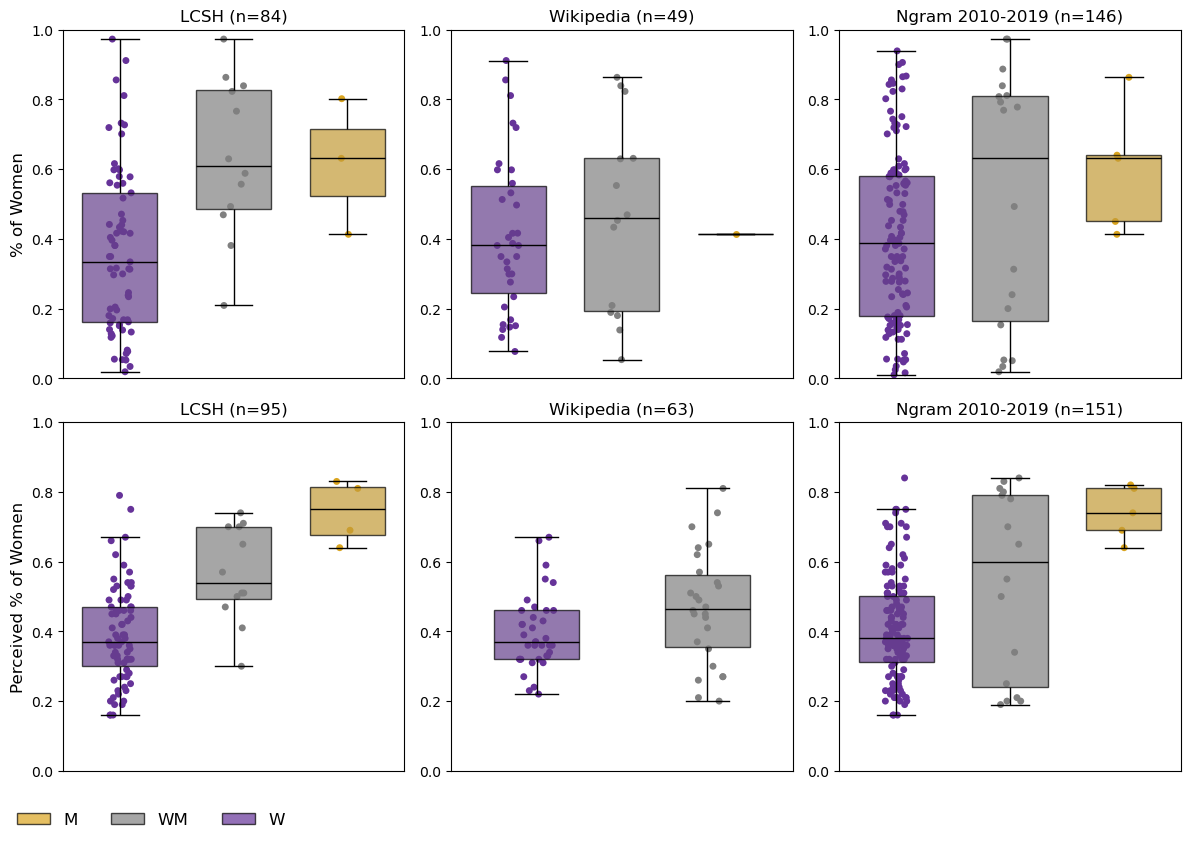

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
palette = ['rebeccapurple', 'grey', 'goldenrod']
y_labels = ['% of Women', 'Perceived % of Women']
dfs = [[jobs_with_prop_lcsh, jobs_with_prop_wiki, jobs_with_prop_lang, jobs_with_prop_lang_20th], [jobs_with_perc_prop_lcsh, jobs_with_perc_prop_wiki, jobs_with_perc_prop_lang, jobs_with_perc_prop_lang_20th]]
system = ['LCSH', 'Wikipedia', 'Ngram 2010-2019', 'Ngram 20th Century']
for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        if 'M' in dfs[i][j]['GENDER'].unique():
            width = 0.66
            order = ['W', 'WM', 'M']
        else:
            width = 0.5
            order = ['W', 'WM']
        sns.stripplot(data=dfs[i][j], y="PROP_W", x="GENDER", palette=palette, order=order,
              orient='v', dodge=False, ax=ax, zorder=0, jitter=0.1)
        sns.boxplot(y='PROP_W', x='GENDER', data=dfs[i][j], ax=ax, palette=['rebeccapurple', 'grey', 'goldenrod'], order=order, showfliers=False,
                orient='v', boxprops={'alpha': 0.7}, linecolor='black', width=width)
        ax.set_ylim(0, 1)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        if j == 0:
            ax.set_ylabel(y_labels[i], fontsize=12)
        else:
            ax.set_ylabel('')
        ax.set_title(f'{system[j]} (n={dfs[i][j].shape[0]})')
        ax.tick_params(axis='x', which='both', bottom=False, top=False)
        if i == 1 and j == 0:
            legend_elements = [mpatches.Patch(facecolor='goldenrod', label='M', edgecolor='black', alpha=0.7),
                            mpatches.Patch(facecolor='grey', label='WM', edgecolor='black', alpha=0.7),
                            mpatches.Patch(facecolor='rebeccapurple', label='W', edgecolor='black', alpha=0.7) ]
            fig.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.005, -0.06), ncol=3,frameon=False, fontsize=12)
        # groups = [group["PROP_W"].values for name, group in dfs[i][j].groupby("GENDER")]
        # kw_test = kruskal(*groups)
        # ax.text(0.905, 0.02, f'p={kw_test.pvalue:.3f}', ha='center', va='center', transform=ax.transAxes)
fig.tight_layout()
fig.savefig('Outputs/Figures/cats_vs_gender_stats.jpeg', dpi=300)

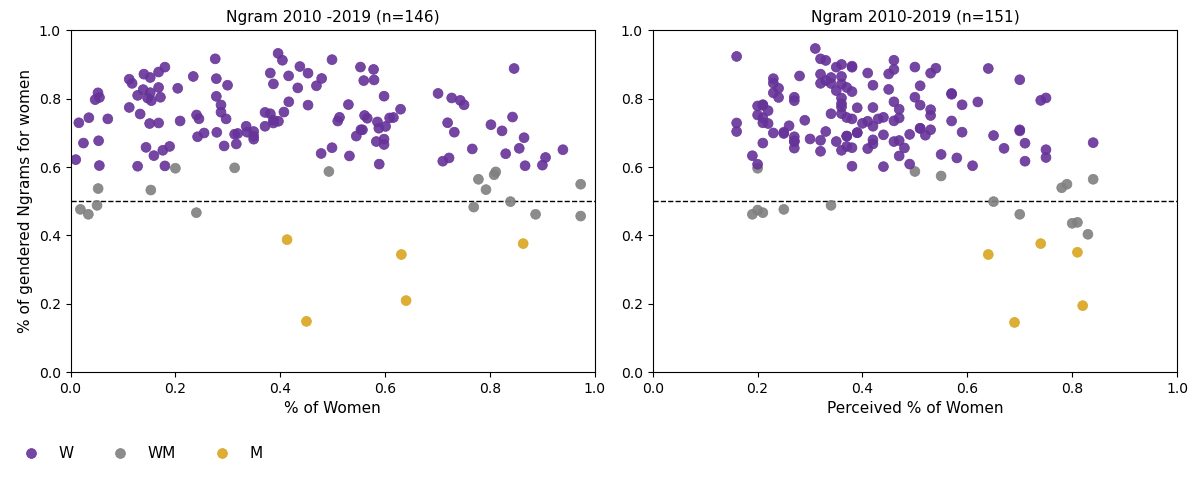

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# ax1, ax3, ax2, ax4 = axes[0,0], axes[1,0], axes[0,1], axes[1,1]
ax1, ax2 = axes[0], axes[1]
sns.scatterplot(data=jobs_with_prop_lang, y='GEN_PROP_W', x='PROP_W', alpha=0.9, ax=ax1, s=50, 
                hue='GENDER', palette=['rebeccapurple', 'grey', 'goldenrod'], legend=True, edgecolor=None)
ax1.set_ylabel('% of gendered Ngrams for women', fontsize=11)
ax1.set_xlabel('% of Women', fontsize=11)
ax1.set_title(f'Ngram 2010 -2019 (n={jobs_with_prop_lang.shape[0]})', fontsize=11)
ax1.set_ylim(0, 1)
ax1.set_xlim(0, 1)
ax1.axline((0, 0.5), (1, 0.5), color='black', linestyle='--', linewidth=1, zorder=0)
ax1.legend(loc='lower left', bbox_to_anchor=(-0.13, -0.3), ncol=3,frameon=False, fontsize=11)



sns.scatterplot(data=jobs_with_perc_prop_lang, y='GEN_PROP_W', x='PROP_W', alpha=0.9, s=50, legend=False,
                 ax=ax2, hue='GENDER', palette=['rebeccapurple', 'grey', 'goldenrod'], edgecolor=None)
ax2.set_ylabel(f'', fontsize=11)
ax2.set_xlabel(f'Perceived % of Women', fontsize=11)
ax2.set_title(f'Ngram 2010-2019 (n={jobs_with_perc_prop_lang.shape[0]})', fontsize=11)
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 1)
ax2.axline((0, 0.5), (1, 0.5), color='black', linestyle='--', linewidth=1, zorder=0)



# sns.scatterplot(data=jobs_with_prop_lang_20th, y='GEN_PROP_W', x='PROP_W', alpha=0.9, s=50, edgecolor=None,
#                  ax=ax3, hue='GENDER', palette=['rebeccapurple', 'grey', 'goldenrod'], legend=False)
# ax3.set_xlabel('% of Women', fontsize=11)
# ax3.set_ylim(0, 1)
# ax3.set_ylabel('')
# ax3.set_title(f'Ngram 20th Century (n={jobs_with_prop_lang_20th.shape[0]})', fontsize=11)
# ax3.set_yticklabels([])
# ax3.set_xticklabels([])
# ax3.set_xlim(0, 1)
# ax3.axline((0, 0.5), (1, 0.5), color='black', linestyle='--', linewidth=1, zorder=0)


# sns.scatterplot(data=jobs_with_perc_prop_lang_20th, y='GEN_PROP_W', x='PROP_W', alpha=0.9, s=50, edgecolor=None,
#                  ax=ax4, hue='GENDER', palette=['rebeccapurple', 'grey', 'goldenrod'], legend=False)
# ax4.set_xlabel(f'Percieved % of Women', fontsize=11)
# ax4.set_ylabel('')
# ax4.set_title(f'Ngram 20th Century (n={jobs_with_perc_prop_lang_20th.shape[0]})', fontsize=11)
# ax4.set_ylim(0, 1)
# ax4.set_yticklabels([])
# ax4.set_xlim(0, 1)
# ax4.axline((0, 0.5), (1, 0.5), color='black', linestyle='--', linewidth=1, zorder=0)

plt.tight_layout()
fig.savefig('Outputs/Figures/Ngram_vs_job_stats.jpeg', dpi=600)




## Cultural Identities
Currently nationalities and ethnicities.

These groups are roughly balanced in terms of their proportions of men and women. Therefore an asymmetry in categories such that their are more gender marked categories for women supports the idea that men are perceived as more typical/representative humans. 

The asymmetry is strong in the LCSH but not in Wikipedia. 

In [23]:
identities_df = pd.read_csv('Data/cultural_identities.txt', sep='\t')

### The LCSH

In [24]:
lcsh_identities = helper.get_gendered_identities(identities_df, lcsh_gendered, ['men', 'male', 'women', 'female'])
w_lcsh_identities, m_lcsh_identities, wm_lcsh_identities = helper.get_concepts(lcsh_identities, ['men', 'male', 'women', 'female'])
total_gendered_lcsh_identities = len(m_lcsh_identities) + len(w_lcsh_identities) + (len(wm_lcsh_identities)*2)
total_identities_lcsh = len(m_lcsh_identities) + len(w_lcsh_identities) + len(wm_lcsh_identities)
asymmetry_lcsh_identities = asymmetry(w_lcsh_identities, m_lcsh_identities)
print(f'There are {total_gendered_lcsh_identities:,} gendered categories for cultural identities in the LCSH that cover {total_identities_lcsh:,} identities.')
print(f'\t-{len(m_lcsh_identities):,} identities just have categories for men')
print(f'\t-{len(w_lcsh_identities):,} identities just have categories for women')
print(f'\t-{len(wm_lcsh_identities):,} identities are gender balanced')

print(f'\nThe gender asymmetry of unbalanced identities is: {asymmetry_lcsh_identities:.3f}.')

There are 215 gendered categories for cultural identities in the LCSH that cover 205 identities.
	-1 identities just have categories for men
	-194 identities just have categories for women
	-10 identities are gender balanced

The gender asymmetry of unbalanced identities is: 0.495.


In [25]:
with open('Outputs/Category Lists/Cultural Identity/w-lcsh-identities.txt', 'w') as f:
    for item in w_lcsh_identities:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Cultural Identity/m-lcsh-identities.txt', 'w') as f:
    for item in m_lcsh_identities:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Cultural Identity/wm-lcsh-identities.txt', 'w') as f:
    for item in wm_lcsh_identities:
        f.write(f"{item}\n")

### Wikipedia

In [26]:
wiki_identities = helper.get_gendered_identities(identities_df, wikipedia_gendered, ['men', 'male', 'women', 'female'])
w_wiki_identities, m_wiki_identities, wm_wiki_identities = helper.get_concepts(wiki_identities, ['men', 'male', 'women', 'female'])
total_gendered_wiki_identities = len(m_wiki_identities) + len(w_wiki_identities) + (len(wm_wiki_identities)*2)
total_identities_wiki = len(m_wiki_identities) + len(w_wiki_identities) + len(wm_wiki_identities)
asymmetry_wiki_identities = asymmetry(w_wiki_identities, m_wiki_identities)

print(f'There are {total_gendered_wiki_identities:,} gendered categories for cultural identities in the Wikipedia that cover {total_identities_wiki:,} identities.')
print(f'\t-{len(m_wiki_identities):,} identities just have categories for men')
print(f'\t-{len(w_wiki_identities):,} identities just have categories for women')
print(f'\t-{len(wm_wiki_identities):,} identities are gender balanced')

print(f'\nThe gender asymmetry of unbalanced identities is: {asymmetry_wiki_identities:.3f}.')


There are 434 gendered categories for cultural identities in the Wikipedia that cover 224 identities.
	-1 identities just have categories for men
	-13 identities just have categories for women
	-210 identities are gender balanced

The gender asymmetry of unbalanced identities is: 0.429.


In [27]:
with open('Outputs/Category Lists/Cultural Identity/w-wiki-identities.txt', 'w') as f:
    for item in w_wiki_identities:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Cultural Identity/m-wiki-identities.txt', 'w') as f:
    for item in m_wiki_identities:
        f.write(f"{item}\n")
with open('Outputs/Category Lists/Cultural Identity/wm-wiki-identities.txt', 'w') as f:
    for item in wm_wiki_identities:
        f.write(f"{item}\n")

### Language (2010-2019)

In [28]:
identities_lang = helper.get_gendered_identities_lang(identities_df, paired_curr)
w_lang_identities, wm_lang_identities, m_lang_identities = helper.get_case_counts(identities_lang)
total_concepts_lang_identities = w_lang_identities + wm_lang_identities + m_lang_identities
asymmetry_lang_identities = (w_lang_identities / (w_lang_identities + m_lang_identities)) - 0.5

print(f'There are {total_concepts_lang_identities:,} cultural identities where both gendered subcategories occur more than {MIN_FREQ} times')
print(f'\t-The are {w_lang_identities:,} where the term for women is much more frequent')
print(f'\t-The are {m_lang_identities:,} where the term for men is much more frequent')
print(f'\t-The are {wm_lang_identities:,} where they occur at roughly equal rates')

print(f'The asymmetry of unbalanced identities is {asymmetry_lang_identities:.3f}')

There are 386 cultural identities where both gendered subcategories occur more than 40 times
	-The are 314 where the term for women is much more frequent
	-The are 14 where the term for men is much more frequent
	-The are 58 where they occur at roughly equal rates
The asymmetry of unbalanced identities is 0.457


### Language (20th Century)

In [29]:
identities_lang_20th = helper.get_gendered_identities_lang(identities_df, paired_20th)
w_lang_identities_20th, wm_lang_identities_20th, m_lang_identities_20th = helper.get_case_counts(identities_lang_20th)
total_concepts_lang_identities_20th = w_lang_identities_20th + wm_lang_identities_20th + m_lang_identities_20th
asymmetry_lang_identities_20th = (w_lang_identities_20th / (w_lang_identities_20th + m_lang_identities_20th)) - 0.5

print(f'There are {total_concepts_lang_identities_20th:,} cultural identities where both gendered subcategories occur more than {MIN_FREQ} times')
print(f'\t-The are {w_lang_identities_20th:,} where the term for women is much more frequent')
print(f'\t-The are {m_lang_identities_20th:,} where the term for men is much more frequent')
print(f'\t-The are {wm_lang_identities_20th:,} where they occur at roughly equal rates')

print(f'\nThe asymmetry of unbalanced identities is {asymmetry_lang_identities_20th:.3f}')

There are 504 cultural identities where both gendered subcategories occur more than 40 times
	-The are 406 where the term for women is much more frequent
	-The are 22 where the term for men is much more frequent
	-The are 76 where they occur at roughly equal rates

The asymmetry of unbalanced identities is 0.449


## Putting it all Together

In [30]:
overall_w = [len(w_lcsh)/total_concepts_lcsh, len(w_wiki)/total_concepts_wiki, w_lang_curr/total_concepts_lang, w_lang_20th/total_concepts_lang_20th]
overall_m = [len(m_lcsh)/total_concepts_lcsh, len(m_wiki)/total_concepts_wiki, m_lang_curr/total_concepts_lang, m_lang_20th/total_concepts_lang_20th]
overall_wm = [len(wm_lcsh)/total_concepts_lcsh, len(wm_wiki)/total_concepts_wiki,wm_lang_curr/total_concepts_lang, wm_lang_20th/total_concepts_lang_20th]

jobs_w = [len(w_lcsh_jobs)/total_jobs_lcsh, len(w_wiki_jobs)/total_jobs_wiki, w_lang_jobs/total_concepts_lang_jobs, w_lang_jobs_20th/total_concepts_lang_jobs_20th]
jobs_m = [len(m_lcsh_jobs)/total_jobs_lcsh, len(m_wiki_jobs)/total_jobs_wiki, m_lang_jobs/total_concepts_lang_jobs, m_lang_jobs_20th/total_concepts_lang_jobs_20th]
jobs_wm = [len(wm_lcsh_jobs)/total_jobs_lcsh, len(wm_wiki_jobs)/total_jobs_wiki, wm_lang_jobs/total_concepts_lang_jobs, wm_lang_jobs_20th/total_concepts_lang_jobs_20th]

identities_w = [len(w_lcsh_identities)/total_identities_lcsh, len(w_wiki_identities)/total_identities_wiki, w_lang_identities/total_concepts_lang_identities, w_lang_identities_20th/total_concepts_lang_identities_20th]
identities_m = [len(m_lcsh_identities)/total_identities_lcsh, len(m_wiki_identities)/total_identities_wiki, m_lang_identities/total_concepts_lang_identities, m_lang_identities_20th/total_concepts_lang_identities_20th]
identities_wm = [len(wm_lcsh_identities)/total_identities_lcsh, len(wm_wiki_identities)/total_identities_wiki, wm_lang_identities/total_concepts_lang_identities, wm_lang_identities_20th/total_concepts_lang_identities_20th]

everything_w = [overall_w, jobs_w, identities_w]
everything_m = [overall_m, jobs_m, identities_m]
everything_wm = [overall_wm, jobs_wm, identities_wm] 

concept_counts = [[total_concepts_lcsh, total_concepts_wiki, total_concepts_lang], 
                  [total_jobs_lcsh, total_jobs_wiki, total_concepts_lang_jobs],
                  [total_identities_lcsh, total_identities_wiki, total_concepts_lang_identities]]

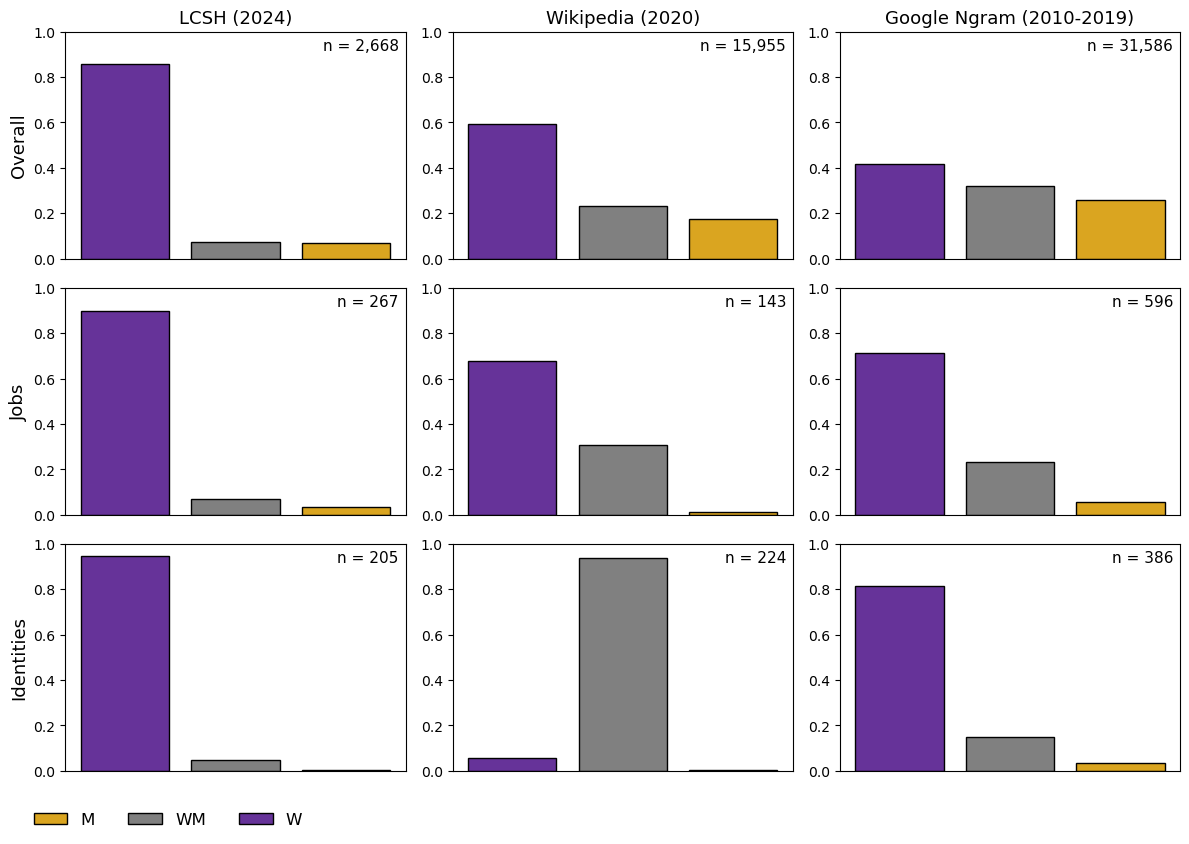

In [31]:
fig, ax = plt.subplots(3, 3, figsize=(12, 8))
labels = ['LCSH (2024)', 'Wikipedia (2020)', 'Google Ngram (2010-2019)', 'Language (20th Century)']
categories = ['Overall', 'Jobs', 'Identities']
for i in range(3):
    for j in range(3):
        if i == 0:
            ax[i, j].set_title(f'{labels[j]}', fontsize=13)
        ax[i, j].bar(['W', 'WM', 'M'], [everything_w[i][j], everything_wm[i][j], everything_m[i][j]], color=['rebeccapurple', 'grey', 'goldenrod'], edgecolor='black')
        ax[i, j].set_xticklabels([])
        ax[i, j].tick_params(axis='x', which='both', bottom=False, top=False)
        ax[i, j].set_ylim(0, 1)
        if j == 0:
            ax[i, j].set_ylabel(categories[i], fontsize=13)
        
        # add total number of concepts to the top right of each plot
        ax[i, j].text(0.98, 0.97, f'n = {concept_counts[i][j]:,}', ha='right', va='top', transform=ax[i, j].transAxes, fontsize=11)
legend_elements = [mpatches.Patch(facecolor='goldenrod', label='M', edgecolor='black'),
                   mpatches.Patch(facecolor='grey', label='WM', edgecolor='black'),
                   mpatches.Patch(facecolor='rebeccapurple', label='W', edgecolor='black') ]
fig.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.02, -0.06), ncol=3,frameon=False, fontsize=12)
plt.tight_layout()
fig.savefig('Outputs/Figures/Bias_by_category.jpeg', dpi=600, bbox_inches='tight')


In [32]:
# make a table of asymmetries

table = tt.Texttable()
table.set_deco(tt.Texttable.HEADER)
table.set_cols_align(['c', 'c', 'c', 'c', 'c', 'c', 'c'])
table.set_cols_valign(['m', 'm', 'm', 'm', 'm', 'm', 'm'])

table.add_rows([['Category', 'LCSH', '', 'Wikipedia', '', 'Ngram', ''],
                ['', 'Asymmetry', '% Unbalanced', 'Asymmetry', '% Unbalanced', 'Asymmetry', '% Unbalanced'],
                ['Overall', f'{asymmetry_lcsh:.3f}', f'{(len(w_lcsh)+ len(m_lcsh))/total_concepts_lcsh:.3f}', f'{asymmetry_wiki:.3f}', f'{(len(w_wiki) + len(m_wiki))/total_concepts_wiki:.3f}', f'{asymmetry_lang:.3f}', f'{(w_lang_curr + m_lang_curr)/total_concepts_lang:.3f}'],
                ['Jobs', f'{asymmetry_lcsh_jobs:.3f}', f'{(len(w_lcsh_jobs) + len(m_lcsh_jobs))/total_jobs_lcsh:.3f}', f'{asymmetry_wiki_jobs:.3f}', f'{(len(w_wiki_jobs) + len(m_wiki_jobs))/total_jobs_wiki:.3f}', f'{asymmetry_lang_jobs:.3f}', f'{(w_lang_jobs + m_lang_jobs)/total_concepts_lang_jobs:.3f}'],
                ['Identities', f'{asymmetry_lcsh_identities:.3f}', f'{(len(w_lcsh_identities) + len(m_lcsh_identities))/total_identities_lcsh:.3f}', f'{asymmetry_wiki_identities:.3f}', f'{(len(w_wiki_identities) + len(m_wiki_identities))/total_identities_wiki:.3f}', f'{asymmetry_lang_identities:.3f}', f'{(w_lang_identities + m_lang_identities)/total_concepts_lang_identities:.3f}']])

print(table.draw())

table = lt.draw_latex(table, caption='Gender asymmetry in the LCSH, Wikipedia, and Google Ngram between 2010 and 2019.', label='tab:asymmetry', use_booktabs=True, caption_above=True)


# save as tex file 
with open('Outputs/Tables/Asymmetry_Table.tex', 'w') as f:
    f.write(table)

Category      LCSH                  Wikipedia                 Ngram             
            Asymmetry   % Unbalan   Asymmetry   % Unbalan   Asymmetry   % Unbala
                           ced                     ced                    nced  
 Overall      0.426       0.927       0.275       0.767       0.116      0.678  
  Jobs        0.464       0.933       0.480       0.692       0.426      0.768  
Identitie     0.495       0.951       0.429       0.062       0.457      0.850  
    s                                                                           
